# Assignment 7: Explainable Machine Learing (Part 1)

## Objective:

Interpreting how a machine learning model works is crucial from many aspects, such as debugging the model, improving the model, and derive new insights from the model. There are many model explanation techniques that we can use for interpreting a black box model itself or its predictions. Also, some models are transparent that we can directly get insights from its structure or learned parameters. In this assignment, you are going to train different models on a dataset and try different approaches to explain the model and get some insights. After completing this assignment, you should be able to answer the following questions:

1. How to explain transparent models?
2. How to implement the permutation method to explain black-box models?
3. How to create and interpret partial dependence plots?
4. How to implement the global surrogate method to explain black-box models?
5. How to use SHAP to explain model predictions and interpret its explanation results? 
6. How to use LIME to explain model predictions and  interpret its explanation results? 

The data can be downloaded from [A7-1-data.zip](A7-1-data.zip)



## 0. Preparation

Import relevant libraries and load the dataset:

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataprep.eda import plot

from sklearn.model_selection import train_test_split
from sklearn.inspection import plot_partial_dependence
from sklearn.metrics import log_loss
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

The dataset we are going to use is a binary forest covertype dataset and we will predict the forest cover type from cartographic variables only. The first ten features are numerical features, there are also two categorical features in a one-hot encoding fashion (4 and 40 vector length each), the last column is the target forest cover type (binary). More details about the dataset can be found at [https://archive.ics.uci.edu/ml/datasets/covertype](https://archive.ics.uci.edu/ml/datasets/covertype). Please make sure you understand the meaning of each feature.

In [2]:
# load data and take a look at data distribution
data = pd.read_csv('bforest_sample.csv', delimiter=',')
plot(data)

GridBox(id='3146', ...)

In [3]:
# split data into training and test dataset with respect to ratio 0.8:0.2
train, test = train_test_split(data, test_size=0.2, random_state=733)
X_train, y_train = train.iloc[:, :-1], train.iloc[:, -1]
X_test, y_test = test.iloc[:, :-1], test.iloc[:, -1]
feature_names = list(X_train)
scaler = MinMaxScaler()
X_train = pd.DataFrame(data=scaler.fit_transform(X_train), columns=feature_names)
X_test = pd.DataFrame(data=scaler.transform(X_test), columns=feature_names)


## Task 1. Transparent Model

In this task, you are going to train a logistic regression model and interpret it. For logistic regression, since the effect of each feature is simply added together, we can interpret it directly by looking at the coefficient of each feature. Please follow the comment to finish the code:

In [4]:
# train a logistic regression model
lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)

In [5]:
# set default figure size
plt.rcParams['figure.figsize'] = [16, 8]

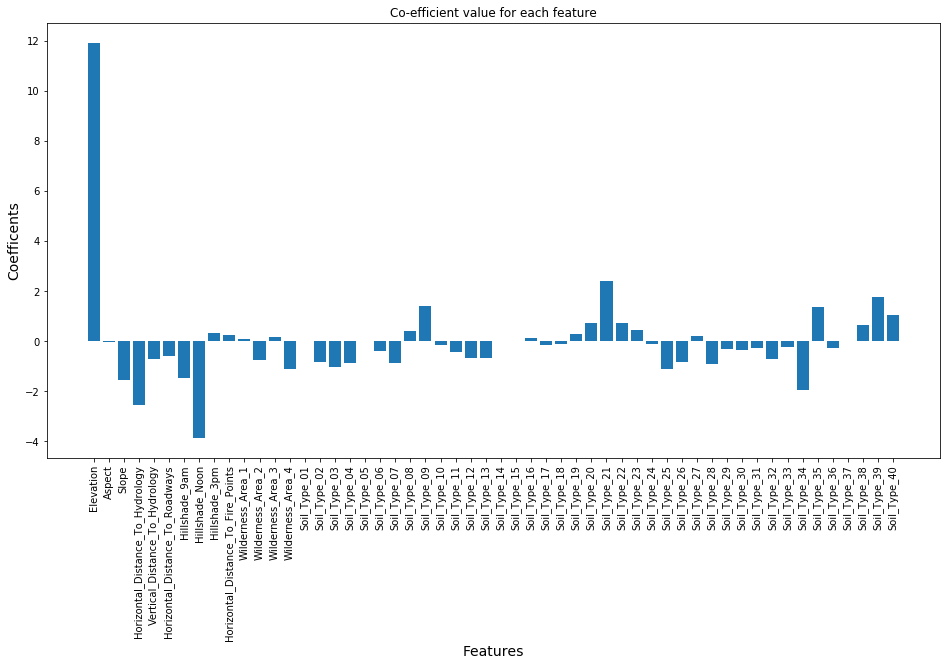

In [6]:
# show the coefficient value for each feature by a bar chart
def explain_logistic_regression(lr, feature_names):
    # --- Write your code below ---
    fig, ax = plt.subplots()
    coeff = lr.coef_.tolist()[0]
    plt.bar(feature_names,coeff)
    plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='center')
    plt.title('Co-efficient value for each feature')
    plt.xlabel('Features', fontsize=14)
    plt.ylabel('Coefficents', fontsize=14)
# explain the model
explain_logistic_regression(lr, feature_names)
plt.show()

For a specific prediction, we can get a more concrete effect of each feature by the product of the coefficient and input feature value. Please follow the comment to finish the code:

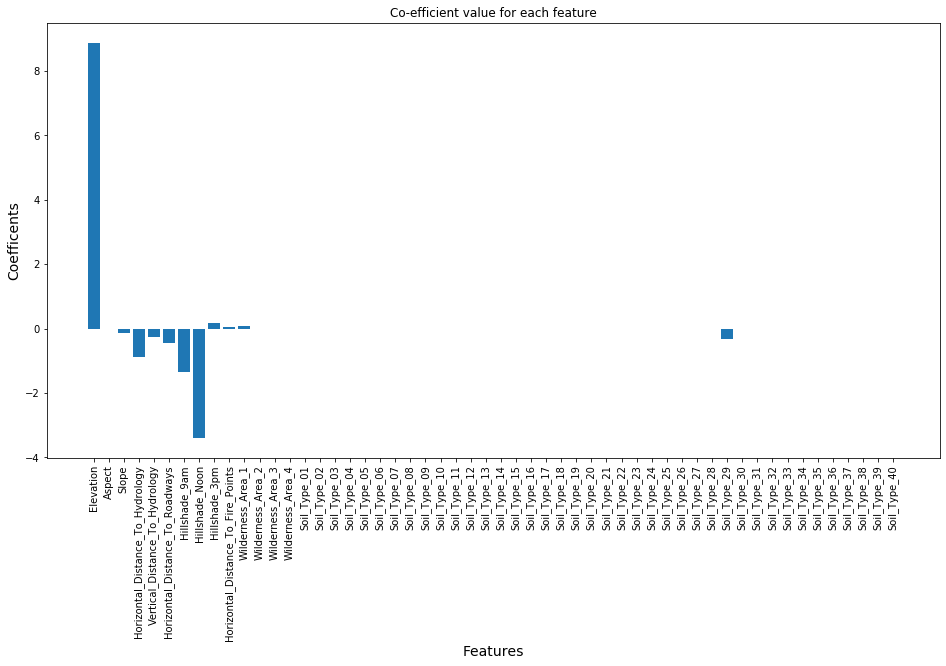

In [7]:
# show the effect from each input feature by a bar chart
def explain_logistic_regression_prediction(lr, feature_names, sample):
    # --- Write your code below ---
    coeff = lr.coef_.tolist()[0]
    effect = []
    for i in range(0,len(coeff)):
        effects = coeff[i] * sample[0][i]
        effect.append(effects)
    fig, ax = plt.subplots()
    plt.bar(feature_names,effect)
    plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='center')
    plt.title('Co-efficient value for each feature')
    plt.xlabel('Features', fontsize=14)
    plt.ylabel('Coefficents', fontsize=14)
explain_logistic_regression_prediction(lr, feature_names, (X_test.iloc[0, :], y_test.iloc[0]))

What can you get from the above plots? Please write down two findings:

**Findings:**
1. It can be noted from the first plot that elevation has the highest importance compared to the rest.It can also be noted that some of Soil Types like 01,14,15 has a coefficient value of 0.
2. When plotting with a single test record, we can note that 11 features have contibuted towards model whose coefficients are depicted above. Rest of the features had no co-efficients. 

## Task 2. Post-hoc Explanation (Global Model)

In this task, you are going to build a gradient boosting tree model and a neural network, and use some techniques we introduced in class to interpret these models. First, let's train the models using training data:

In [8]:
# train a gradient boosting classifier
gb = GradientBoostingClassifier().fit(X_train, y_train)

In [9]:
# train a multi-layer perceptron classifier
mlp = MLPClassifier(learning_rate_init=0.1).fit(X_train, y_train)

### 2.1 Permutation

In [10]:
# get importance score (E' - E) for each feature by permutation, use log_loss as error
def permutation_importance(model, feature_names, X, y):
    # calculate importance score for each feature by purmutation approach
    # --- Write your code below ---
    # Finding the probability 
    gb_probs = gb.predict_proba(X)
    # Calculating log loss of entire y to get score E
    E = log_loss(y, gb_probs)
    # Below code is to randomly shuffle each column and then calculate the respective log loss.A list-
    # of importance score is finally created
    P_imp = [] 
    X_beg = np.array(X)
    for j in range(np.shape(X)[1]):
        np.random.shuffle(X_beg[:,j])
        gb_probs = gb.predict_proba(X_beg)
        E1 = log_loss(y, gb_probs)
        score = E1 - E
        P_imp.append(score)
        X_beg = np.empty_like (X)
        X_beg[:] = X
    # show the top 5 most important features
    # --- Write your code below ---
    feature_imp = pd.DataFrame({'feature_names': feature_names,'importance': P_imp})
    feature_imp = feature_imp.sort_values(by=['importance'], ascending=False)
    print(feature_imp.head())

print("Important features of gradient boost model are")
permutation_importance(gb, feature_names, X_test.to_numpy(), y_test.to_numpy())
print("\nImportant features of multi layer perceptron boost model are")
permutation_importance(mlp, feature_names, X_test.to_numpy(), y_test.to_numpy())

Important features of gradient boost model are
                        feature_names  importance
0                           Elevation    0.368638
5     Horizontal_Distance_To_Roadways    0.032191
3    Horizontal_Distance_To_Hydrology    0.025225
7                      Hillshade_Noon    0.022766
9  Horizontal_Distance_To_Fire_Points    0.014624

Important features of multi layer perceptron boost model are
                        feature_names  importance
0                           Elevation    0.380753
5     Horizontal_Distance_To_Roadways    0.034506
3    Horizontal_Distance_To_Hydrology    0.024390
7                      Hillshade_Noon    0.022106
9  Horizontal_Distance_To_Fire_Points    0.015884


### 2.2 Partial dependence plots

In this section, you are going to use the [plot_partial_dependence](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.plot_partial_dependence.html#sklearn.inspection.plot_partial_dependence) provided by sklearn to see the marginal effect of each single numerical features:

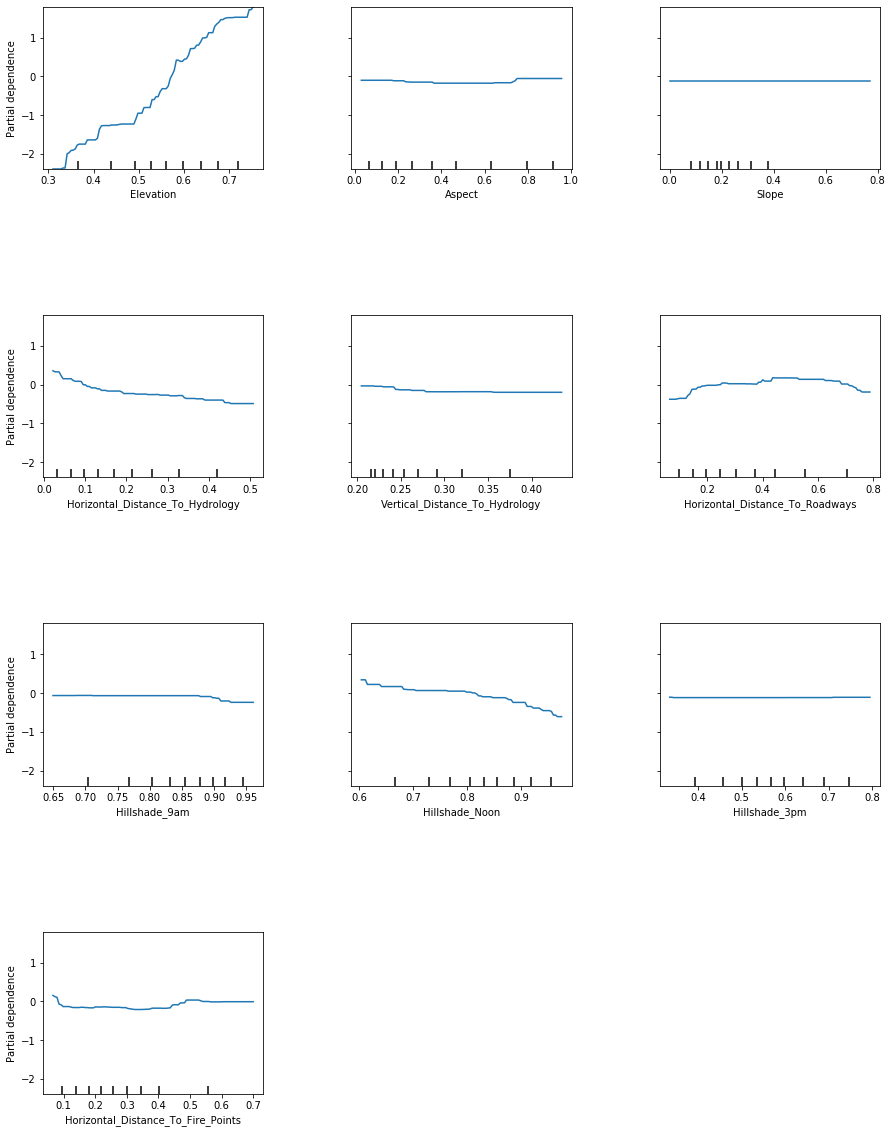

In [11]:
###### plot partial dependence for numerical features (first 10 features) for gradient boosting classifier
# --- Write your code below ---
plot_partial_dependence(gb,features=[0,1,2,3,4,5,6,7,8,9],X=X_test,feature_names=feature_names[0:10])
fig = plt.gcf()
fig.subplots_adjust(wspace=0.4,hspace=0.9)
fig.set_size_inches(15,20)

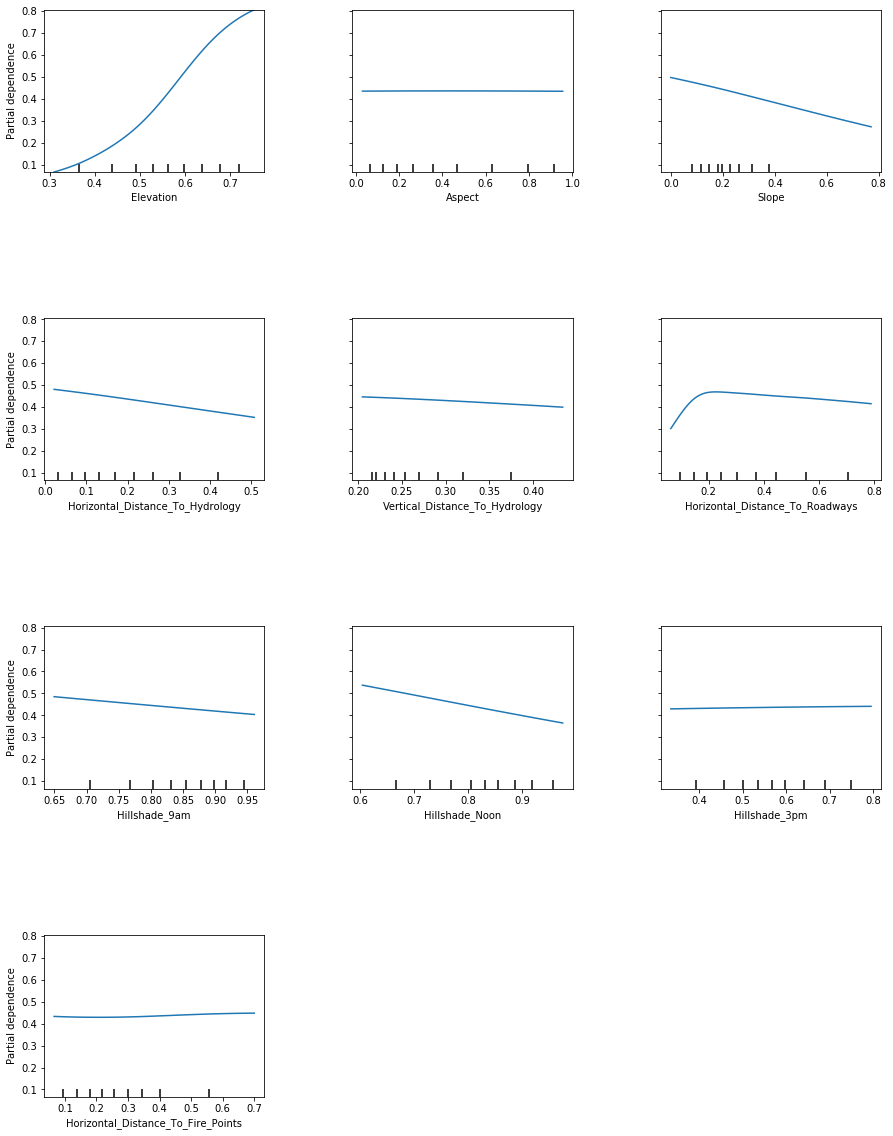

In [12]:
# plot partial dependence for numerical features (first 10 features) for neural network
# --- Write your code below ---
plot_partial_dependence(mlp,features=[0,1,2,3,4,5,6,7,8,9],X=X_test,feature_names=feature_names[0:10])
fig = plt.gcf()
fig.subplots_adjust(wspace=0.4,hspace=0.9)
fig.set_size_inches(15,20)

### 2.3 Global Surrogate

Now, let's train a simple logistic regression based on the gradient boosting tree model and neural network we built before. And use the method we implemented previously to interpret the derived transparent model:

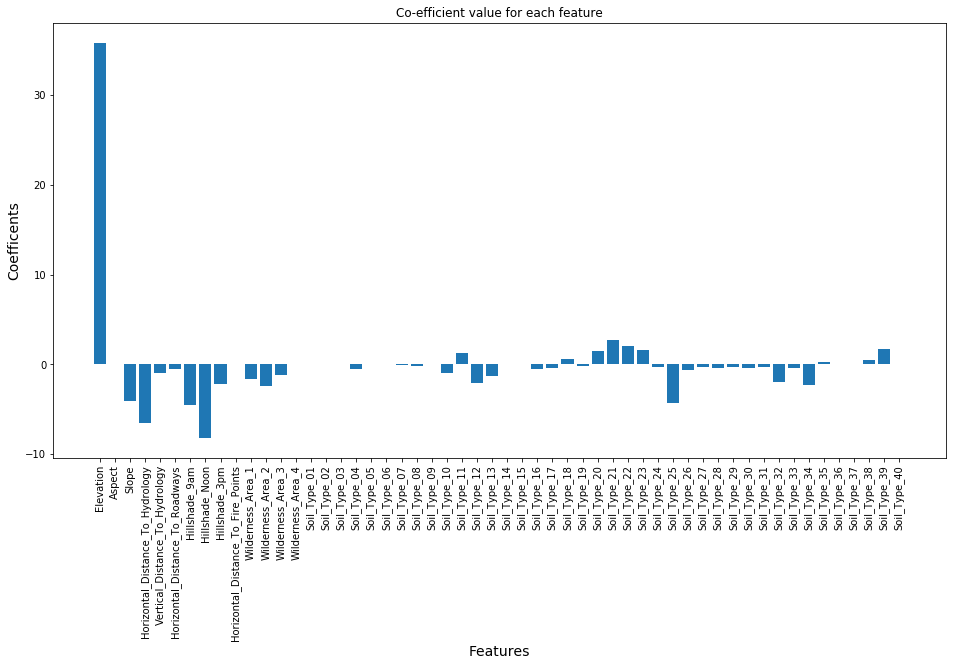

In [14]:
# train a logistic regression model on gb and mlp and explain using explain_logistic_regression()

# --- Write your code below ---
gb_pred = gb.predict(X_train)
lr_gb = LogisticRegression(solver='liblinear').fit(X_train, gb_pred)
explain_logistic_regression(lr_gb, feature_names)

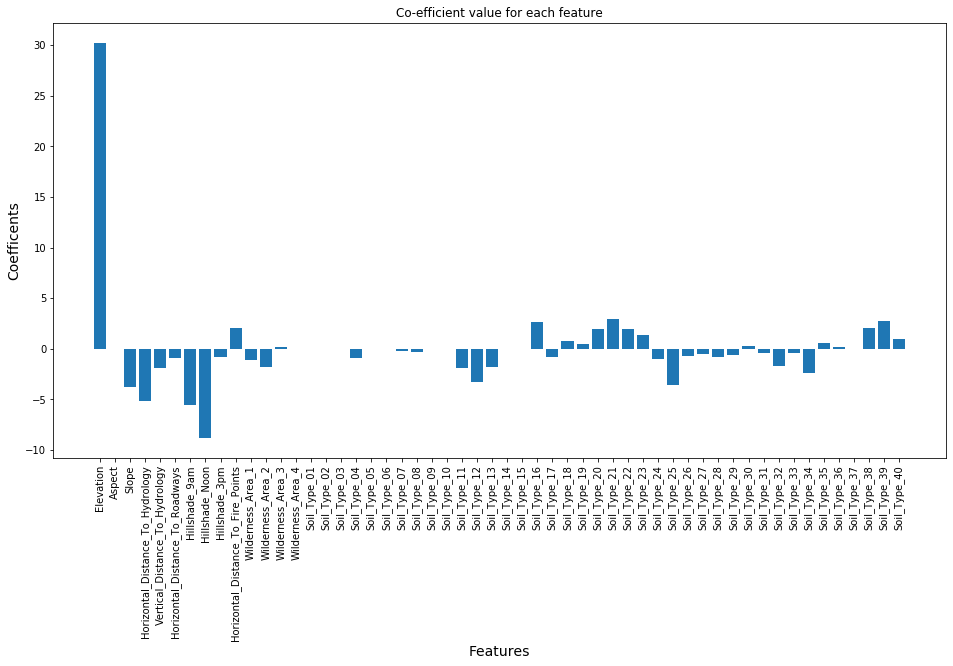

In [15]:
mlp_pred = mlp.predict(X_train)
lr_mlp = LogisticRegression(solver='liblinear').fit(X_train, mlp_pred)
explain_logistic_regression(lr_mlp, feature_names)


## Task 3. Post-hoc Explanation (Single Prediction)

### 3.1 Attribution

From now, let's focus on interpreting single predictions. [SHAP](https://github.com/slundberg/shap) is an efficient method to approximatly calculate the shapely value we mentioned in class. Please install the library and take a look at the doc. Explain the first prediction made by the gradient boosting tree model in the test set:

In [16]:
import shap

# load JS visualization code to notebook
shap.initjs()

# use Tree SHAP explainer to explain the gradient boosting tree model
# you only need to explain and plot the first explaination
# --- Write your code below ---
Xtest_copy = X_test.copy()
Xtest_copy["prediction"] = gb.predict(Xtest_copy)
shap_model = shap.TreeExplainer(gb)
shap_value = shap_model.shap_values(Xtest_copy.iloc[0])
shap.force_plot(shap_model.expected_value, shap_value, Xtest_copy.iloc[0])


Setting feature_perturbation = "tree_path_dependent" because no background data was given.
The sklearn.ensemble.gradient_boosting module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.


What can you get from the above representation? Please write down two findings:

**Findings:**
1. It can be noted that feature named 'elevation' has pushed the prediction to a higher side from based value of -0.4003.This feature is indicated in red.
2. Features such as Soil_Type_29 and Horizontal_Distance_To_Roadways have contributed in pushing the prediction to lower side. These features are indicated in blue

### 3.2 LIME

[LIME](https://github.com/marcotcr/lime) is a library implemented by the authors of the paper. Please install the library and take a look at the doc and tutorial. Use it to explain the first prediction made by the neural network model in the test set:

In [19]:
import lime
import lime.lime_tabular

# use LimeTabularExplainer to explain the neural network model
# you only need to explain and plot the first explaination
# --- Write your code below ---
target_names = np.array(["Type0","Type1"])
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.to_numpy(), feature_names=feature_names,class_names=target_names,discretize_continuous=True)
exp = explainer.explain_instance(X_test.to_numpy()[0], mlp.predict_proba, num_features=54)
exp.show_in_notebook(show_table=True)

Run LIME multiple times, (Q1) what do you think of the stability of LIME? (Q2) Can you briefly explain the reason?

**Your Answer:** 
1. It can be observed that LIME is not stable as each run produces different results.
2. Explanations produced from LIME are the results of a random sampling process. Hence we would not get the same result every time when we run.

## Submission
Complete the code in this notebook, and submit it to the CourSys activity Assignment 7.